In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
base_path = 'C:/Users/SYYAD/Documents/MSAI/AI in Healthcare/NLP/'

**Load Data**

In [5]:
# Primary Admissions information
# Add'.gz' if you uploaded .gz file
df = pd.read_csv(base_path + "ADMISSIONS.csv", low_memory=False)  
# df = pd.read_csv('ADMISSIONS.csv.gz')

# Patient specific info such as gender
df_pat = pd.read_csv(base_path + "PATIENTS.csv", low_memory=False)  

# Diagnosis for each admission to hospital
df_diagcode = pd.read_csv(base_path + "DIAGNOSES_ICD.csv", low_memory=False)  

# Intensive Care Unit (ICU) for each admission to hospital
df_icu = pd.read_csv(base_path + "ICUSTAYS.csv", low_memory=False)  

**Feature Engineering: ADMISSIONS Table**

In [6]:
list(df)

['ROW_ID',
 'SUBJECT_ID',
 'HADM_ID',
 'ADMITTIME',
 'DISCHTIME',
 'DEATHTIME',
 'ADMISSION_TYPE',
 'ADMISSION_LOCATION',
 'DISCHARGE_LOCATION',
 'INSURANCE',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'ETHNICITY',
 'EDREGTIME',
 'EDOUTTIME',
 'DIAGNOSIS',
 'HOSPITAL_EXPIRE_FLAG',
 'HAS_CHARTEVENTS_DATA']

In [7]:
df["HOSPITAL_EXPIRE_FLAG"].value_counts()

HOSPITAL_EXPIRE_FLAG
0    53122
1     5854
Name: count, dtype: int64

In [8]:
print('Dataset has {} number of unique admission events.'.format(df['HADM_ID'].nunique()))
print('Dataset has {} number of unique patients.'.format(df['SUBJECT_ID'].nunique()))

Dataset has 58976 number of unique admission events.
Dataset has 46520 number of unique patients.


In [9]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [10]:
# Convert admission and discharge times to datatime type
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])

# Convert timedelta type into float 'days', 86400 seconds in a day
df['LOS'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.total_seconds()/86400

In [11]:
# Verify
df[['ADMITTIME', 'DISCHTIME', 'LOS']].head()

,ADMITTIME,DISCHTIME,LOS
0,2196-04-09 12:26:00,2196-04-10 15:54:00,1.144444
1,2153-09-03 07:15:00,2153-09-08 19:10:00,5.496528
2,2157-10-18 19:34:00,2157-10-25 14:00:00,6.768056
3,2139-06-06 16:14:00,2139-06-09 12:48:00,2.856944
4,2160-11-02 02:06:00,2160-11-05 14:55:00,3.534028


In [12]:
df['LOS'].describe()

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

In [13]:
# Look at what is happening with negative LOS values
df[df['LOS'] < 0]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS
425,534,417,102633,2177-03-23 16:17:00,2177-03-23 07:20:00,2177-03-23 07:20:00,URGENT,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,NaN,NaN,ORGAN DONOR ACCOUNT,1,1,-0.372917
456,237,181,102631,2153-10-12 09:49:00,2153-10-12 06:29:00,2153-10-12 06:29:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,NaN,PROTESTANT QUAKER,MARRIED,WHITE,2153-10-12 06:23:00,2153-10-12 07:45:00,DISSECTING ANEURYSIM,1,1,-0.138889
692,644,516,187482,2197-07-31 20:18:00,2197-07-31 01:10:00,2197-07-31 01:10:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,JEWISH,WIDOWED,UNKNOWN/NOT SPECIFIED,2197-07-31 11:31:00,2197-07-31 14:35:00,RESPIRATORY DISTRESS,1,0,-0.797222
1911,1640,1334,138015,2137-09-02 14:43:00,2137-09-02 12:00:00,2137-09-02 12:00:00,NEWBORN,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,NaN,PROTESTANT QUAKER,NaN,WHITE,NaN,NaN,NEWBORN,1,1,-0.113194
1970,1699,1381,181430,2189-01-02 14:25:00,2189-01-02 12:00:00,2189-01-02 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,UNOBTAINABLE,MARRIED,WHITE,2189-01-02 10:31:00,2189-01-02 15:56:00,STROKE;TELEMETRY,1,1,-0.100694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57233,57980,96810,165589,2103-09-25 20:38:00,2103-09-25 12:00:00,2103-09-25 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,RUSS,UNOBTAINABLE,WIDOWED,WHITE,2103-09-25 19:27:00,2103-09-25 21:37:00,CARDIAC ARREST,1,1,-0.359722
57559,58635,98943,193747,2164-11-14 20:03:00,2164-11-14 12:00:00,2164-11-14 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,UNOBTAINABLE,MARRIED,WHITE,2164-11-14 18:24:00,2164-11-14 20:54:00,INTRACRANIAL HEMORRHAGE,1,1,-0.335417
57902,58720,99207,191004,2143-07-06 19:59:00,2143-07-06 12:00:00,2143-07-06 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,ENGL,CATHOLIC,DIVORCED,WHITE,2143-07-06 19:30:00,2143-07-06 20:05:00,GSW L. CHEST WALL & ABDOMEN,1,1,-0.332639
58346,55950,90642,101946,2122-04-24 14:36:00,2122-04-24 12:00:00,2122-04-24 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,MARRIED,UNABLE TO OBTAIN,NaN,NaN,ST-SEGMENT ELEVATION MYOCARDIAL INFARCTION\CATH,1,1,-0.108333


In [14]:
# Drop rows with negative LOS, usually related to a time of death before admission
df['LOS'][df['LOS'] > 0].describe()

count    58878.000000
mean        10.151266
std         12.459774
min          0.001389
25%          3.755556
50%          6.489583
75%         11.805556
max        294.660417
Name: LOS, dtype: float64

In [15]:
# Drop LOS < 0
df = df[df['LOS'] > 0]

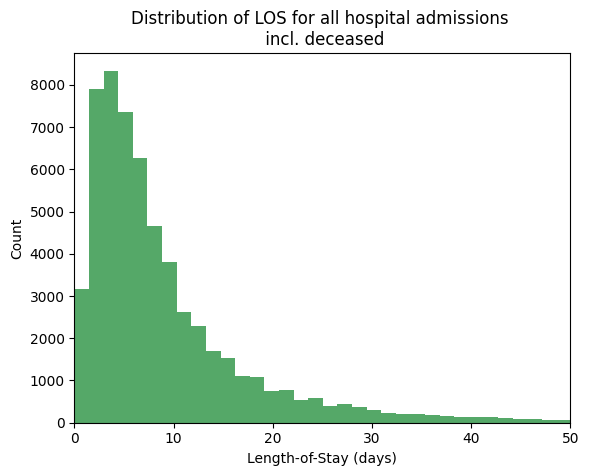

In [16]:
# Plot LOS Distribution
plt.hist(df['LOS'], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False)
plt.show();

In [17]:
# Pre-emptively drop some columns that I don't need anymore
df.drop(columns=['DISCHTIME', 'ROW_ID',
                'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG',
                'HAS_CHARTEVENTS_DATA'], inplace=True)

In [18]:
# Mark admissions where patients died in boolean column
df['DECEASED'] = df['DEATHTIME'].notnull().map({True:1, False:0})

In [19]:
print("{} of {} patients died in the hospital".format(df['DECEASED'].sum(),
                                                     df['SUBJECT_ID'].nunique()))

5774 of 46445 patients died in the hospital


In [20]:
df.head()


,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,LOS,DECEASED
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,1.144444,0
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,5.496528,0
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,BRAIN MASS,6.768056,0
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,2.856944,0
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,3.534028,0


In [21]:
df['DECEASED'][df['DECEASED']== 1].describe()

count    5774.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: DECEASED, dtype: float64

In [22]:
df[df['DECEASED']==1].head()


,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,LOS,DECEASED
9,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,MARRIED,WHITE,STATUS EPILEPTICUS,7.647917,1
57,56,181711,2104-01-02 02:01:00,2104-01-08 10:30:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,NOT SPECIFIED,NaN,WHITE,HEAD BLEED,6.353472,1
63,61,189535,2119-01-04 18:12:00,2119-02-03 01:35:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,NaN,CATHOLIC,MARRIED,WHITE,NON-HODGKINS LYMPHOMA;FEBRILE;NEUTROPENIA,29.307639,1
70,67,155252,2157-12-02 00:45:00,2157-12-02 03:55:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,JEWISH,SINGLE,WHITE,SUBARACHNOID HEMORRHAGE,0.131944,1
88,84,166401,2196-04-14 04:02:00,2196-04-17 13:42:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,NaN,OTHER,MARRIED,WHITE,"GLIOBLASTOMA,NAUSEA",3.402778,1


In [23]:
# Look at statistics less admissions resulting in death
df['LOS'].loc[df['DECEASED'] == 0].describe()

count    53104.000000
mean        10.138174
std         12.284461
min          0.014583
25%          3.866667
50%          6.565972
75%         11.711632
max        294.660417
Name: LOS, dtype: float64

In [24]:
# Hospital LOS metrics for later comparison
actual_mean_los = df['LOS'].loc[df['DECEASED'] == 0].mean()
actual_median_los = df['LOS'].loc[df['DECEASED'] == 0].median()

print(actual_mean_los)
print(actual_median_los)

10.138173704219813
6.565972222222222


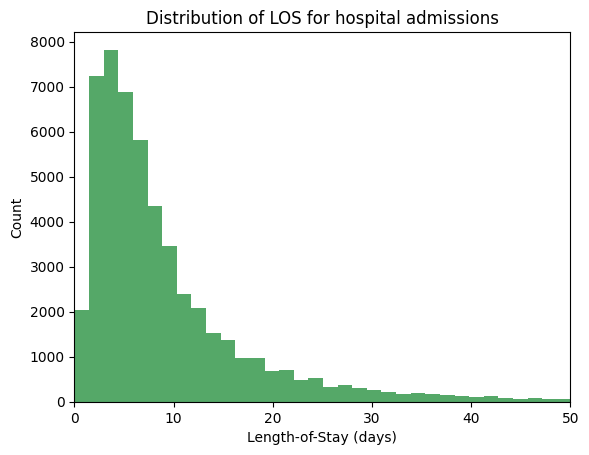

In [25]:
plt.hist(df['LOS'].loc[df['DECEASED'] == 0], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for hospital admissions')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False)
plt.show();

In [26]:
df['ETHNICITY'].value_counts()

ETHNICITY
WHITE                                                       40939
BLACK/AFRICAN AMERICAN                                       5434
UNKNOWN/NOT SPECIFIED                                        4502
HISPANIC OR LATINO                                           1693
ASIAN                                                        1508
OTHER                                                        1507
UNABLE TO OBTAIN                                              809
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85


In [27]:
# Compress the number of ethnicity categories
df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER',
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['ETHNICITY'].loc[~df['ETHNICITY'].isin(df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df['ETHNICITY'].value_counts()

C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\1325925633.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\1325925633.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

ETHNICITY
WHITE                     41268
OTHER/UNKNOWN              7700
BLACK/AFRICAN AMERICAN     5779
HISPANIC/LATINO            2125
ASIAN                      2006
Name: count, dtype: int64

C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\1364745201.py:36: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax.boxplot(hist_data, 0, '', vert=False)


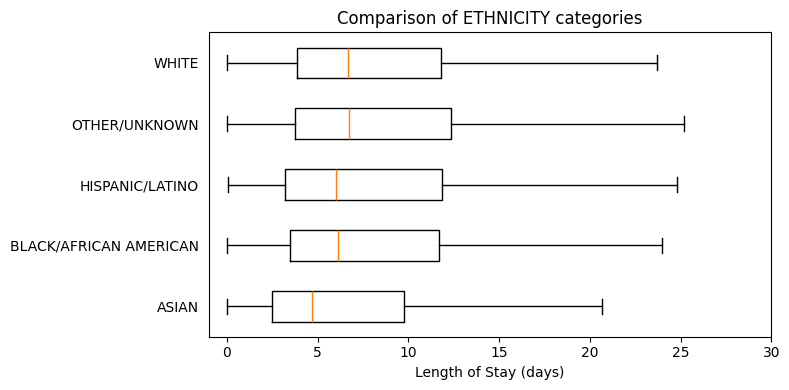

In [28]:
# Re-usable plotting function
def plot_los_groupby(variable, size=(7,4)):
    '''
    Plot Median LOS by df categorical series name
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False)
    ax.set_title('Comparison of {} labels'.format(variable))

    plt.tight_layout()
    plt.show();

# Re-usable boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    '''
    Boxplot of LOS by df categorical series name
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df['LOS'].loc[df[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False)
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

boxplot_los_groupby('ETHNICITY', los_range=(-1, 30))

In [29]:
df['RELIGION'].value_counts()

RELIGION
CATHOLIC                  20580
NOT SPECIFIED             11738
UNOBTAINABLE               8242
PROTESTANT QUAKER          7121
JEWISH                     5307
OTHER                      2695
EPISCOPALIAN                771
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: count, dtype: int64

C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\1364745201.py:36: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax.boxplot(hist_data, 0, '', vert=False)


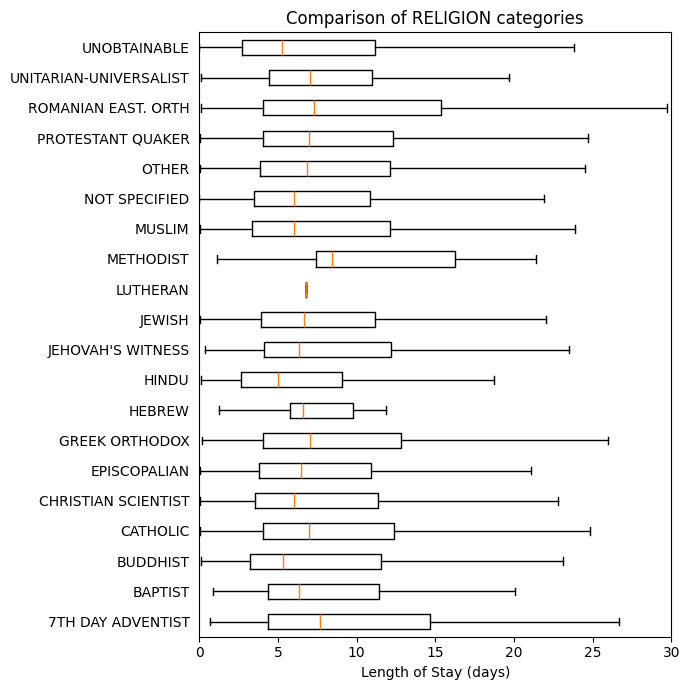

In [30]:
boxplot_los_groupby('RELIGION', los_range=(0, 30), size=(7, 7))

In [31]:
# Reduce categories to terms of religious or not
# I tested with and without category reduction, with little change in R2 score
df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

print(df['RELIGION'].value_counts())
print(df['RELIGION'].value_counts()[0]/len(df['RELIGION']))
print(df['RELIGION'].value_counts()[1]/len(df['RELIGION']))
print(df['RELIGION'].value_counts()[2]/len(df['RELIGION']))

RELIGION
RELIGIOUS        38898
NOT SPECIFIED    11738
UNOBTAINABLE      8242
Name: count, dtype: int64
0.6606542341791501
0.1993613913516084
0.13998437446924147


C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\2507947393.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'
C:\Users\SYYAD\AppData\Local\Temp\ipyk

In [32]:
df.head()


,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,LOS,DECEASED
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,1.144444,0
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,5.496528,0
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,MARRIED,WHITE,BRAIN MASS,6.768056,0
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,2.856944,0
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,3.534028,0


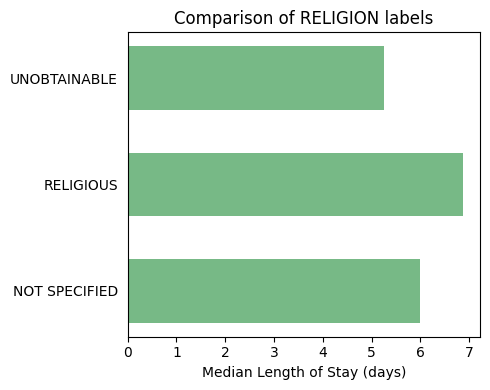

In [33]:
# Look at median LOS for groups
plot_los_groupby('RELIGION', size=(5,4))

In [34]:
df['ADMISSION_TYPE'].value_counts()

ADMISSION_TYPE
EMERGENCY    41989
NEWBORN       7854
ELECTIVE      7702
URGENT        1333
Name: count, dtype: int64

C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\1364745201.py:36: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax.boxplot(hist_data, 0, '', vert=False)


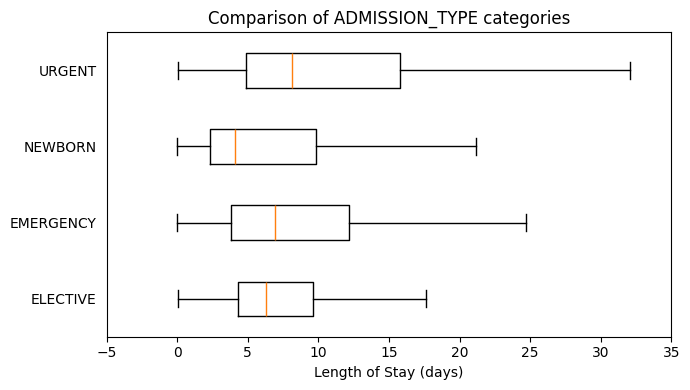

In [35]:
boxplot_los_groupby('ADMISSION_TYPE', los_range=(-5, 35), size=(7, 4))

In [36]:
df['INSURANCE'].value_counts()

INSURANCE
Medicare      28174
Private       22542
Medicaid       5778
Government     1781
Self Pay        603
Name: count, dtype: int64

C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\1364745201.py:36: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax.boxplot(hist_data, 0, '', vert=False)


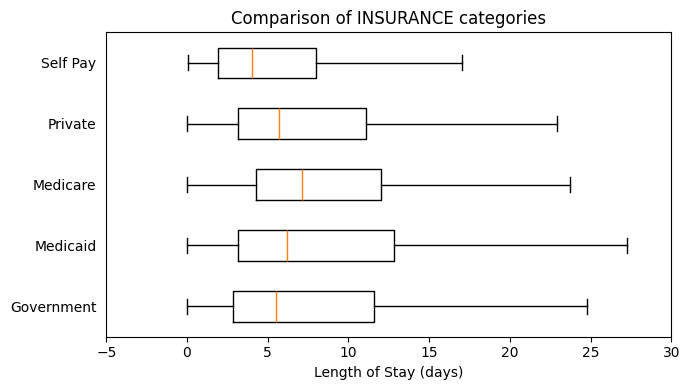

In [37]:
boxplot_los_groupby('INSURANCE', los_range=(-5, 30), size=(7, 4))

In [38]:
df['MARITAL_STATUS'].value_counts(dropna=False)

MARITAL_STATUS
MARRIED              24199
SINGLE               13238
NaN                  10097
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
UNKNOWN (DEFAULT)      343
LIFE PARTNER            15
Name: count, dtype: int64

In [39]:
# Fix NaNs and file under 'UNKNOWN'
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df['MARITAL_STATUS'].value_counts(dropna=False)

MARITAL_STATUS
MARRIED              24199
SINGLE               13238
UNKNOWN (DEFAULT)    10440
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
LIFE PARTNER            15
Name: count, dtype: int64

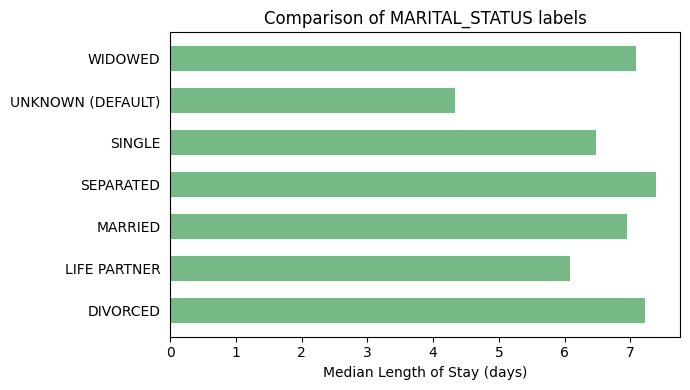

In [40]:
plot_los_groupby('MARITAL_STATUS')

C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\1364745201.py:36: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax.boxplot(hist_data, 0, '', vert=False)


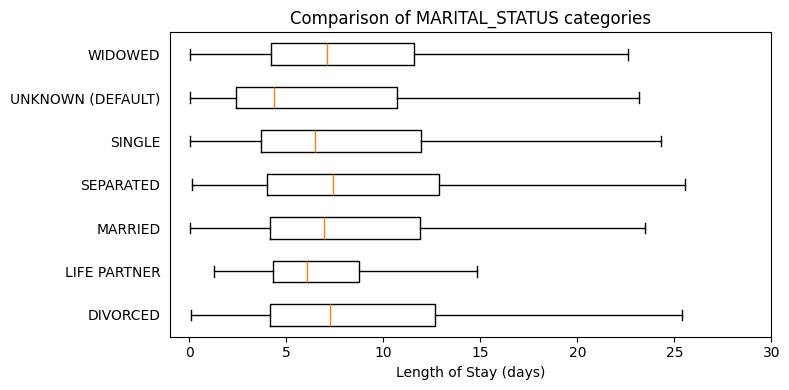

In [41]:
boxplot_los_groupby('MARITAL_STATUS')

**Feature Engineering: DIAGNOSES_ICD Table**

In [43]:
df_diagcode = pd.read_csv(base_path + "DIAGNOSES_ICD.csv", low_memory=False)

In [44]:
df_diagcode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ROW_ID      651047 non-null  int64  
 1   SUBJECT_ID  651047 non-null  int64  
 2   HADM_ID     651047 non-null  int64  
 3   SEQ_NUM     651000 non-null  float64
 4   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [45]:
print('There are {} unique ICD9 codes in this dataset.'.format(df_diagcode['ICD9_CODE'].value_counts().count()))

There are 6984 unique ICD9 codes in this dataset.


In [46]:
df_diagcode.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [47]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['ICD9_CODE']
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)

C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\534943549.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\534943549.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the 

In [48]:
# https://stackoverflow.com/questions/46168450/replace-specific-range-of-values-in-data-frame-pandas
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

In [49]:
list(df_diagcode)

['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE', 'recode']

In [50]:
df_diagcode.head()


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,recode
0,1297,109,172335,1.0,40301,403
1,1298,109,172335,2.0,486,486
2,1299,109,172335,3.0,58281,582
3,1300,109,172335,4.0,5855,585
4,1301,109,172335,5.0,4254,425


In [51]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin',
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]),
            num, df_diagcode['recode'])

# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

In [52]:
# Verify
df_diagcode.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,recode,cat
0,1297,109,172335,1.0,40301,6,circulatory
1,1298,109,172335,2.0,486,7,respiratory
2,1299,109,172335,3.0,58281,9,genitourinary
3,1300,109,172335,4.0,5855,9,genitourinary
4,1301,109,172335,5.0,4254,6,circulatory


In [53]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['ICD9_CODE']
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin',
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0], cat_range[1]),
                                     num, df_diagcode['recode'])

# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

# Verify
print(df_diagcode.head())

C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\384778453.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\384778453.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the 

   ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE  recode            cat
0    1297         109   172335      1.0     40301       6    circulatory
1    1298         109   172335      2.0       486       7    respiratory
2    1299         109   172335      3.0     58281       9  genitourinary
3    1300         109   172335      4.0      5855       9  genitourinary
4    1301         109   172335      5.0      4254       6    circulatory


In [54]:
# Create list of diagnoses for each admission
hadm_list = df_diagcode.groupby('HADM_ID')['cat'].apply(list).reset_index()
hadm_list.head()

,HADM_ID,cat
0,100001,"[endocrine, nervous, genitourinary, digestive,..."
1,100003,"[digestive, blood, infectious, digestive, circ..."
2,100006,"[respiratory, respiratory, respiratory, neopla..."
3,100007,"[digestive, digestive, injury, respiratory, ci..."
4,100009,"[circulatory, injury, circulatory, endocrine, ..."


In [56]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0


In [57]:
# Join back with HADM_ID, will merge with main admissions DF later
hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,HADM_ID
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1,100001
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,100003
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0,100006
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,100007
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0,100009


In [58]:
# Merge with main admissions df
df = df.merge(hadm_item, how='inner', on='HADM_ID')

In [59]:
# Verify Merge
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,4,1,0,0,0,1,0,0,0,0
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,1,0,0,0,0,1,0,0,0,0
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,3,0,0,0,1,1,0,1,0,0
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,0,0,0
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Comparison of Diagnoses')

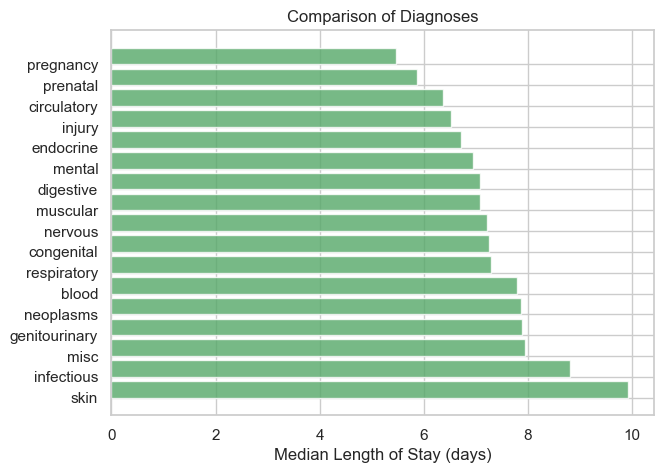

In [60]:
# Look at the median LOS by diagnosis category
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory',
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal',  'pregnancy']

results = []
for variable in diag_cat_list:
    results.append(df[[variable, 'LOS']].groupby(variable).median().reset_index().values[1][1])

sns.set(style="whitegrid")
#sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Median Length of Stay (days)')
ax.tick_params(left=False, right=False, top=False)
ax.set_title('Comparison of Diagnoses'.format(variable))

**Feature Engineering: Patients Table**

In [62]:
df_pat = pd.read_csv(base_path + "PATIENTS.csv", low_memory=False)  

In [63]:
df_pat.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [64]:
df_pat['GENDER'].value_counts()

GENDER
M    26121
F    20399
Name: count, dtype: int64

In [65]:
# Convert to datetime type
df_pat['DOB'] = pd.to_datetime(df_pat['DOB'])

In [66]:
df_pat = df_pat[['SUBJECT_ID', 'DOB', 'GENDER']]
df_pat.head()

,SUBJECT_ID,DOB,GENDER
0,249,2075-03-13,F
1,250,2164-12-27,F
2,251,2090-03-15,M
3,252,2078-03-06,M
4,253,2089-11-26,F


In [67]:
df = df.merge(df_pat, how='inner', on='SUBJECT_ID')

In [68]:
df.head()


,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,DOB,GENDER
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,0,0,0,1,0,0,0,0,2131-05-07,F
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,0,0,0,1,0,0,0,0,2082-07-17,M
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,0,0,1,1,0,1,0,0,2082-07-17,M
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,0,2100-05-31,M
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,0,0,0,0,0,2101-11-21,M


In [69]:
# Find the first admission time for each patient
df_age_min = df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
df_age_min.head()

,SUBJECT_ID,ADMIT_MIN
0,2,2138-07-17 19:04:00
1,3,2101-10-20 19:08:00
2,4,2191-03-16 00:28:00
3,5,2103-02-02 04:31:00
4,6,2175-05-30 07:15:00


In [70]:
df = df.merge(df_age_min, how='outer', on='SUBJECT_ID')

In [71]:
# Verify merge
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,DOB,GENDER,ADMIT_MIN
0,2,163353,2138-07-17 19:04:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,...,0,0,0,0,0,0,0,2138-07-17,M,2138-07-17 19:04:00
1,3,145834,2101-10-20 19:08:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,RELIGIOUS,...,0,0,0,0,0,0,1,2025-04-11,M,2101-10-20 19:08:00
2,4,185777,2191-03-16 00:28:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,2143-05-12,F,2191-03-16 00:28:00
3,5,178980,2103-02-02 04:31:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,2103-02-02,M,2103-02-02 04:31:00
4,6,107064,2175-05-30 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,...,0,0,0,0,0,0,0,2109-06-21,F,2175-05-30 07:15:00


In [72]:
df['ADMIT_MIN'] = pd.to_datetime(df['ADMIT_MIN']).dt.date
df['DOB'] = pd.to_datetime(df['DOB']).dt.date
df['age'] = df.apply(lambda e: (e['ADMIT_MIN'] - e['DOB']).days/365, axis=1)

#df['ADMIT_MIN'] = pd.to_datetime(df['ADMIT_MIN'])
#df['DOB'] = pd.to_datetime(df['DOB'])
#df['age'] = (df['ADMIT_MIN'].sub(df['DOB'], axis=0))// np.timedelta64(1, 'Y')
print(df.head())
#df['age'].isnull().sum()

   SUBJECT_ID  HADM_ID           ADMITTIME DEATHTIME ADMISSION_TYPE  \
0           2   163353 2138-07-17 19:04:00       NaN        NEWBORN   
1           3   145834 2101-10-20 19:08:00       NaN      EMERGENCY   
2           4   185777 2191-03-16 00:28:00       NaN      EMERGENCY   
3           5   178980 2103-02-02 04:31:00       NaN        NEWBORN   
4           6   107064 2175-05-30 07:15:00       NaN       ELECTIVE   

          ADMISSION_LOCATION         DISCHARGE_LOCATION INSURANCE LANGUAGE  \
0  PHYS REFERRAL/NORMAL DELI                       HOME   Private      NaN   
1       EMERGENCY ROOM ADMIT                        SNF  Medicare      NaN   
2       EMERGENCY ROOM ADMIT  HOME WITH HOME IV PROVIDR   Private      NaN   
3  PHYS REFERRAL/NORMAL DELI                       HOME   Private      NaN   
4  PHYS REFERRAL/NORMAL DELI           HOME HEALTH CARE  Medicare     ENGL   

        RELIGION  ... neoplasms nervous pregnancy  prenatal  respiratory  \
0  NOT SPECIFIED  ...       

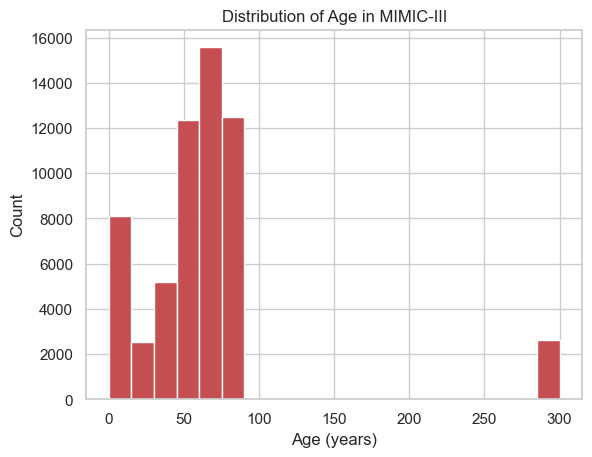

In [73]:
# Note that no ‘middle’ patients show up - this reflects the fact that MIMIC-III does not contain data from pediatric patients.
plt.hist(df['age'], bins=20, color='#c44e52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False)
plt.show();

(1.0, 50.0)

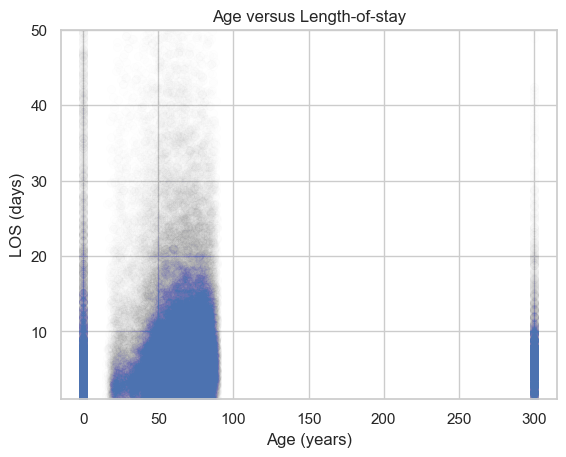

In [75]:
plt.scatter(df['age'], df['LOS'], alpha=0.005)
#plt.yscale('sqrt')
plt.ylabel('LOS (days)')
plt.xlabel('Age (years)')
plt.title('Age versus Length-of-stay')
plt.ylim(1, 50)

In [76]:
# https://en.wikipedia.org/wiki/List_of_ICD-9_codes
age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
for num, cat_range in enumerate(age_ranges):
    df['age'] = np.where(df['age'].between(cat_range[0],cat_range[1]),
            num, df['age'])

age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
df['age'] = df['age'].replace(age_dict)
df.age.value_counts()

age
senior          32091
middle_adult    12077
newborn          8101
young_adult      3999
300.2            2610
Name: count, dtype: int64

C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\1364745201.py:36: MatplotlibDeprecationWarning: Passing the notch parameter of boxplot() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax.boxplot(hist_data, 0, '', vert=False)


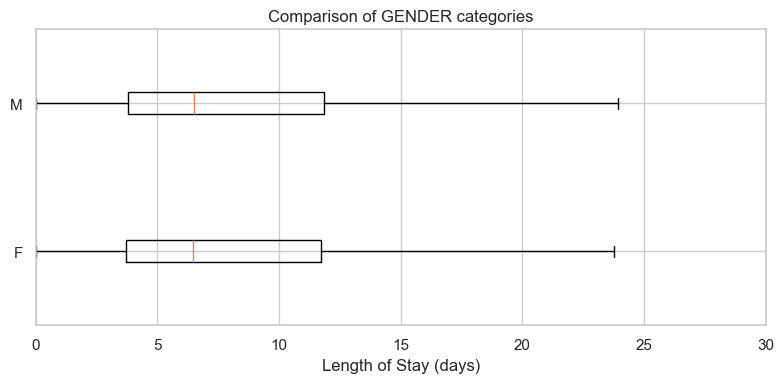

C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\1687169820.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)
C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\1687169820.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['GENDER'].replace({

In [77]:
boxplot_los_groupby('GENDER', los_range=(0, 30))
df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)

**Feature Engineering: ICUSTAYS Table**

In [79]:
df_icu = pd.read_csv(base_path + "ICUSTAYS.csv", low_memory=False)  

In [80]:
# Intensive Care Unit (ICU) for each admission to hospital
df_icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          61532 non-null  int64  
 1   SUBJECT_ID      61532 non-null  int64  
 2   HADM_ID         61532 non-null  int64  
 3   ICUSTAY_ID      61532 non-null  int64  
 4   DBSOURCE        61532 non-null  object 
 5   FIRST_CAREUNIT  61532 non-null  object 
 6   LAST_CAREUNIT   61532 non-null  object 
 7   FIRST_WARDID    61532 non-null  int64  
 8   LAST_WARDID     61532 non-null  int64  
 9   INTIME          61532 non-null  object 
 10  OUTTIME         61522 non-null  object 
 11  LOS             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


In [81]:
df_icu['HADM_ID'].nunique()

57786

In [83]:
df_icu.groupby('FIRST_CAREUNIT').median(numeric_only=True)

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_WARDID,LAST_WARDID,LOS
FIRST_CAREUNIT,,,,,,,
CCU,29091.5,22964.5,150074.5,249373.5,7.0,7.0,2.19775
CSRU,31002.5,24488.0,150225.0,250492.0,14.0,14.0,2.15290
MICU,33612.5,26489.5,150368.0,250524.0,50.0,50.0,2.09550
NICU,19581.5,15456.5,149206.5,249308.0,56.0,56.0,0.80250
SICU,38089.0,30084.0,149744.0,248649.0,33.0,33.0,2.25220
TSICU,36382.0,28716.0,148915.0,250685.0,14.0,14.0,2.11150


In [84]:
# Based on above statistics, reduce to just ICU and NICU groups
df_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

In [85]:
df_icu['cat'] = df_icu['FIRST_CAREUNIT']
icu_list = df_icu.groupby('HADM_ID')['cat'].apply(list).reset_index()
icu_list.head()

,HADM_ID,cat
0,100001,[ICU]
1,100003,[ICU]
2,100006,[ICU]
3,100007,[ICU]
4,100009,[ICU]


In [86]:
df_icu['FIRST_CAREUNIT'].value_counts()

FIRST_CAREUNIT
ICU     53432
NICU     8100
Name: count, dtype: int64

In [88]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
icu_item.head()

,ICU,NICU,HADM_ID
0,1,0,100001
1,1,0,100003
2,1,0,100006
3,1,0,100007
4,1,0,100009


In [89]:

print("Number of admissions to ICU {}.".format(icu_item.ICU.sum()))
print("Number of admissions to NICU {}.".format(icu_item.NICU.sum()))

Number of admissions to ICU 49794.
Number of admissions to NICU 7992.


In [90]:
# Merge ICU data with main dataFrame
df = df.merge(icu_item, how='outer', on='HADM_ID')

In [91]:
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,pregnancy,prenatal,respiratory,skin,DOB,GENDER,ADMIT_MIN,age,ICU,NICU
0,58526.0,100001,2117-09-11 11:46:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,RELIGIOUS,...,0.0,0.0,0.0,1.0,2082-03-21,1.0,2117-09-11,young_adult,1.0,0.0
1,54610.0,100003,2150-04-17 15:34:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,NOT SPECIFIED,...,0.0,0.0,0.0,0.0,2090-05-19,0.0,2150-04-17,senior,1.0,0.0
2,9895.0,100006,2108-04-06 15:49:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,NOT SPECIFIED,...,0.0,0.0,3.0,0.0,2059-05-07,1.0,2108-04-06,middle_adult,1.0,0.0
3,23018.0,100007,2145-03-31 05:33:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,RELIGIOUS,...,0.0,0.0,1.0,0.0,2071-06-04,1.0,2145-03-31,senior,1.0,0.0
4,533.0,100009,2162-05-16 15:56:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Private,NaN,RELIGIOUS,...,0.0,0.0,0.0,0.0,2101-07-30,0.0,2162-05-16,senior,1.0,0.0


In [92]:
# Replace NaNs with 0
df['ICU'].fillna(value=0, inplace=True)
df['NICU'].fillna(value=0, inplace=True)

C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\1541659716.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ICU'].fillna(value=0, inplace=True)
C:\Users\SYYAD\AppData\Local\Temp\ipykernel_11596\1541659716.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

In [93]:

# Verify NaN fix
print(df.ICU.value_counts(dropna=False))
print(df.NICU.value_counts(dropna=False))

ICU
1.0    49794
0.0     9168
Name: count, dtype: int64
NICU
0.0    50970
1.0     7992
Name: count, dtype: int64


**Data Cleaning and Data Splitting**

In [94]:
# Look at what is no longer needed in the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58962 entries, 0 to 58961
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SUBJECT_ID          58878 non-null  float64       
 1   HADM_ID             58962 non-null  int64         
 2   ADMITTIME           58878 non-null  datetime64[ns]
 3   DEATHTIME           5774 non-null   object        
 4   ADMISSION_TYPE      58878 non-null  object        
 5   ADMISSION_LOCATION  58878 non-null  object        
 6   DISCHARGE_LOCATION  58878 non-null  object        
 7   INSURANCE           58878 non-null  object        
 8   LANGUAGE            33606 non-null  object        
 9   RELIGION            58878 non-null  object        
 10  MARITAL_STATUS      58878 non-null  object        
 11  ETHNICITY           58878 non-null  object        
 12  DIAGNOSIS           58853 non-null  object        
 13  LOS                 58878 non-null  float64   

In [95]:
# Remove deceased persons as they will skew LOS result
df = df[df['DECEASED'] == 0]

# Remove LOS with negative number, likely entry form error
df = df[df['LOS'] > 0]

In [96]:
# Drop unused or no longer needed columns
df.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION',
                'DISCHARGE_LOCATION', 'LANGUAGE', 'ADMIT_MIN', 'DOB',
                'DIAGNOSIS', 'DECEASED',  'DEATHTIME'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53104 entries, 0 to 58961
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ADMISSION_TYPE  53104 non-null  object 
 1   INSURANCE       53104 non-null  object 
 2   RELIGION        53104 non-null  object 
 3   MARITAL_STATUS  53104 non-null  object 
 4   ETHNICITY       53104 non-null  object 
 5   LOS             53104 non-null  float64
 6   blood           53104 non-null  float64
 7   circulatory     53104 non-null  float64
 8   congenital      53104 non-null  float64
 9   digestive       53104 non-null  float64
 10  endocrine       53104 non-null  float64
 11  genitourinary   53104 non-null  float64
 12  infectious      53104 non-null  float64
 13  injury          53104 non-null  float64
 14  mental          53104 non-null  float64
 15  misc            53104 non-null  float64
 16  muscular        53104 non-null  float64
 17  neoplasms       53104 non-null  floa

In [97]:
df.head()

,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,LOS,blood,circulatory,congenital,digestive,...,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,GENDER,age,ICU,NICU
0,EMERGENCY,Private,RELIGIOUS,DIVORCED,WHITE,6.207639,0.0,2.0,0.0,2.0,...,0.0,2.0,0.0,0.0,0.0,1.0,1.0,young_adult,1.0,0.0
1,EMERGENCY,Private,NOT SPECIFIED,SINGLE,WHITE,4.080556,1.0,2.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,senior,1.0,0.0
2,EMERGENCY,Private,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,12.061806,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,3.0,0.0,1.0,middle_adult,1.0,0.0
3,EMERGENCY,Private,RELIGIOUS,MARRIED,WHITE,7.296528,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,senior,1.0,0.0
4,EMERGENCY,Private,RELIGIOUS,MARRIED,WHITE,4.903472,1.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,senior,1.0,0.0


In [98]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'REL', 'ETH', 'AGE', 'MAR', 'RELIGION']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY', 'age', 'MARITAL_STATUS', 'RELIGION']
df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53104 entries, 0 to 58961
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LOS                         53104 non-null  float64
 1   blood                       53104 non-null  float64
 2   circulatory                 53104 non-null  float64
 3   congenital                  53104 non-null  float64
 4   digestive                   53104 non-null  float64
 5   endocrine                   53104 non-null  float64
 6   genitourinary               53104 non-null  float64
 7   infectious                  53104 non-null  float64
 8   injury                      53104 non-null  float64
 9   mental                      53104 non-null  float64
 10  misc                        53104 non-null  float64
 11  muscular                    53104 non-null  float64
 12  neoplasms                   53104 non-null  float64
 13  nervous                     53104 no

In [99]:
# Verify
df.head()

,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,MAR_DIVORCED,MAR_LIFE PARTNER,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED,RELIGION_NOT SPECIFIED,RELIGION_RELIGIOUS,RELIGION_UNOBTAINABLE
0,6.207639,0.0,2.0,0.0,2.0,5.0,2.0,0.0,2.0,0.0,...,True,False,False,False,False,False,False,False,True,False
1,4.080556,1.0,2.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,...,False,False,False,False,True,False,False,True,False,False
2,12.061806,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,...,False,False,False,False,True,False,False,True,False,False
3,7.296528,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,...,False,False,True,False,False,False,False,False,True,False
4,4.903472,1.0,7.0,0.0,0.0,3.0,0.0,0.0,7.0,0.0,...,False,False,True,False,False,False,False,False,True,False


In [100]:
# Target Variable (Length-of-Stay)
LOS = df['LOS'].values
# Prediction Features
features = df.drop(columns=['LOS'])

In [101]:
features.head()


,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,...,MAR_DIVORCED,MAR_LIFE PARTNER,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED,RELIGION_NOT SPECIFIED,RELIGION_RELIGIOUS,RELIGION_UNOBTAINABLE
0,0.0,2.0,0.0,2.0,5.0,2.0,0.0,2.0,0.0,0.0,...,True,False,False,False,False,False,False,False,True,False
1,1.0,2.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,...,False,False,False,False,True,False,False,True,False,False
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,...,False,False,False,False,True,False,False,True,False,False
3,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,...,False,False,True,False,False,False,False,False,True,False
4,1.0,7.0,0.0,0.0,3.0,0.0,0.0,7.0,0.0,0.0,...,False,False,True,False,False,False,False,False,True,False


In [102]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    LOS,
                                                    test_size = .20,
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 42483 samples.
Testing set has 10621 samples.


**Machine Learning Models**

In [103]:
# Regression models for comparison
models = [SGDRegressor(random_state = 0),
          GradientBoostingRegressor(random_state = 0),
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results = {}

for model in models:

    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)

    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)

    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

SGDRegressor done.
GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.


Text(0.5, 1.0, 'Comparison of Regression Models')

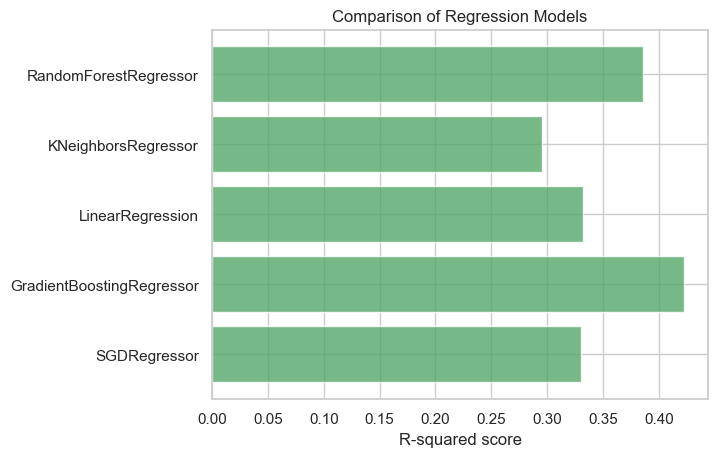

In [104]:
# R2 score results
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center',
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False)
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [105]:
# GradientBoostingRegressor will be used as the LOS prediction model
reg_model = GradientBoostingRegressor(random_state=0)
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

R2 score is: 0.422946


**Model Finetuning**

In [106]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    LOS,
                                                    test_size = .20,
                                                    random_state = 42)

# Set the parameters by cross-validation
#tuned_parameters = [{'n_estimators': [100, 200, 300],
#                     'max_depth' : [2, 3, 4],
#                     'loss': ['ls', 'lad', 'huber']}]
tuned_parameters = [{'n_estimators': [200, 300],
                     'max_depth' : [3, 4],
                     'loss': ['squared_error', 'absolute_error']}]

# create and fit a ridge regression model, testing each alpha
reg_model = GradientBoostingRegressor()
grid = GridSearchCV(reg_model, tuned_parameters)
grid.fit(X_train, y_train)
reg_model_optimized = grid.best_estimator_

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

0.40634241008763167
GradientBoostingRegressor(max_depth=4, n_estimators=300)


In [107]:
#reg_model = GradientBoostingRegressor(n_estimators = 200, max_depth=4, random_state=0)
#reg_model.fit(X_train, y_train)
y_test_preds = reg_model_optimized.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized))

Optimized R2 score is: 0.373599


In [109]:

print('Model refinement improved R2 score by {:.4f}'.format(r2_optimized-r2_not_refined))

Model refinement improved R2 score by -0.0493


**Evaluation**

In [110]:
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_imp = pd.DataFrame(reg_model_optimized.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)

,importance
prenatal,0.401578
respiratory,0.111783
infectious,0.103930
digestive,0.083298
nervous,0.081581
injury,0.035479
skin,0.020009
congenital,0.017314
genitourinary,0.016302
circulatory,0.016001


In [111]:
feature_imp.index[0:10].tolist()

['prenatal',
 'respiratory',
 'infectious',
 'digestive',
 'nervous',
 'injury',
 'skin',
 'congenital',
 'genitourinary',
 'circulatory']

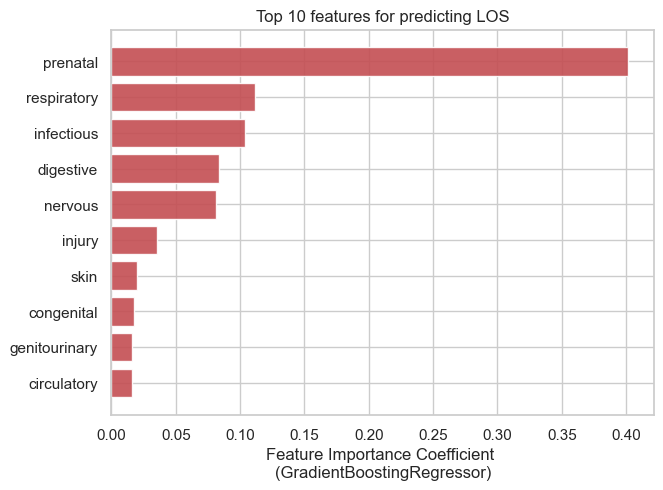

In [112]:

# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10],
        align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False)
ax.set_title("Top 10 features for predicting LOS")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()
#fig.savefig('images/feature_importance.png', bbox_inches = 'tight')

Prediction Model days 5.5226954970978985
Median Model days 6.427673947839196
Average Model days 7.235765892517812
Prediction Model RMS 0.09300811347839501
Median Model RMS 0.12256797714023587
Average Model RMS 0.11751550834686907


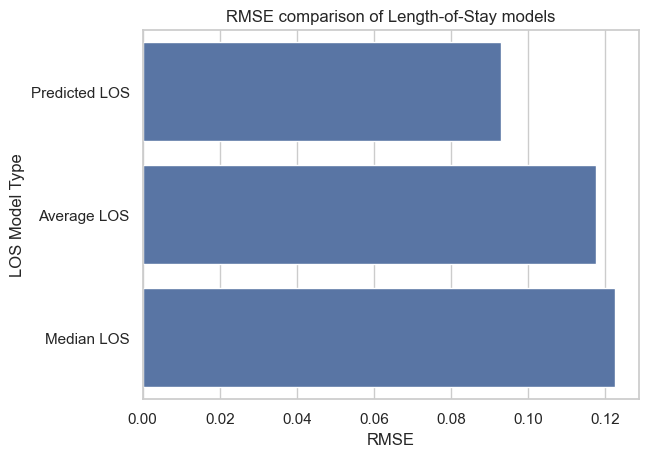

In [113]:
actual_avg_los = df['LOS'].mean()
ml_count, md_count, avg_count = 0, 0, 0
ml_days, md_days, avg_days = 0, 0, 0
ml_days_rms, md_days_rms, avg_days_rms = 0, 0, 0

for i in range(y_test_preds.shape[0]):
    ml_model = abs(y_test_preds[i] - y_test[i])
    median_model = abs(actual_median_los - y_test[i])
    average_model = abs(actual_avg_los - y_test[i])

    ml_days += ml_model
    md_days += median_model
    avg_days += average_model

    ml_model_rms = (y_test_preds[i] - y_test[i]) ** 2
    median_model_rms = (actual_median_los - y_test[i]) ** 2
    average_model_rms = (actual_avg_los - y_test[i]) ** 2

    ml_days_rms += ml_model_rms
    md_days_rms += median_model_rms
    avg_days_rms += average_model_rms

print("Prediction Model days {}".format(ml_days / y_test_preds.shape[0]))
print("Median Model days {}".format(md_days / y_test_preds.shape[0]))
print("Average Model days {}".format(avg_days / y_test_preds.shape[0]))

print("Prediction Model RMS {}".format((ml_days_rms ** 0.5) / y_test_preds.shape[0]))
print("Median Model RMS {}".format((md_days_rms ** 0.5) / y_test_preds.shape[0]))
print("Average Model RMS {}".format((avg_days_rms ** 0.5) / y_test_preds.shape[0]))
# RMSE plot for writeup
data = pd.DataFrame({'RMSE': [(ml_days_rms**0.5)/y_test_preds.shape[0],
                             (avg_days_rms**0.5)/y_test_preds.shape[0],
                             (md_days_rms**0.5)/y_test_preds.shape[0]],
                     'LOS Model Type': ['Predicted LOS', 'Average LOS', 'Median LOS'] })

fig, ax = plt.subplots()
ax = sns.barplot(x='RMSE', y='LOS Model Type', data=data)
ax.set_title('RMSE comparison of Length-of-Stay models')
ax.tick_params(top=False, left=False, right=False)

plt.show()